In [1]:
import numpy as np
import os
import scipy
import h5py 
import pandas as pd
import bigbadbrain as bbb
from scipy.interpolate import interp1d
import matplotlib
import matplotlib.pyplot as plt
from time import strftime
%matplotlib inline

In [2]:
def extract_stimulus_data(data):
    direction = []
    coherence = []
    unix_time = []
    pre_time = []
    stim_time = []
    tail_time = []
    
    epoch = 1
    while True:
        epoch_str = str(epoch).zfill(3)
        try:
            # note series changes for each fly...
            epoch_data = data['epochs'][F'epoch_{epoch_str}']
        except KeyError:
            break

        direction.append(epoch_data.attrs['coherence_direction'])
        coherence.append(epoch_data.attrs['coherence'])
        unix_time.append(epoch_data.attrs['epoch_unix_time'])
        pre_time.append(epoch_data.attrs['pre_time'])
        stim_time.append(epoch_data.attrs['stim_time'])
        tail_time.append(epoch_data.attrs['tail_time'])

        epoch +=1
        
    stim_data = {"direction": direction,
                 "coherence": coherence,
                 "unix_time": unix_time,
                 "pre_time": pre_time,
                 "stim_time": stim_time,
                 "tail_time": tail_time}
    return stim_data
        
def extract_fictrac_data(data):
    fictrac_data = data['behavior']['fictrac_data'][:]
    fictrac_data_header = data['behavior']['fictrac_data'].attrs['fictrac_data_header']
    
    ### Get rotation velocity
    smoothing = 25
    idx = np.where(fictrac_data_header=='rel_vec_world_z')[0][0] #this is'dRotLabZ'
    turning_smoothed = scipy.signal.savgol_filter(np.asarray(fictrac_data[:,idx]),smoothing,3)
    
    ### Get timestamps
    idx = np.where(fictrac_data_header=='timestamp')[0][0]
    beh_time_og = list(fictrac_data[:,idx])
    beh_time_og = [i/1000 for i in beh_time_og] # convert to seconds
    
    fictrac = {"turning": turning_smoothed,
               "time": beh_time_og}
    
    return fictrac

def interpolate(fictrac_data, stim_data, resolution):
    expt_len = fictrac_data["time"][-1] - fictrac_data["time"][0] # in sec
    
    # set first time as t=0
    t0 = fictrac_data["time"][0]
    beh_time = [i-t0 for i in fictrac_data["time"]]
    fictrac_interp_temp = interp1d(beh_time, fictrac_data['turning'], bounds_error = False)
    xnew = np.arange(0,expt_len,resolution) #0 to last time at subsample res
    fictrac_interp = fictrac_interp_temp(xnew)
    fictrac_data['interp'] = fictrac_interp*180/np.pi*300 ### convert to deg/sec
    fictrac_data['interp_time'] = xnew
    
    # also subtract t0 here
    stim_data['time'] = [i-t0 for i in stim_data["unix_time"]]
    
    return fictrac_data, stim_data

def extract_beh_traces(fictrac_data, stim_data, resolution):
    ### grab the behavior at each stimulus
    ### timestamps refer to the beginning of the pre-stimulus
    
    # take first epoch since they all should have same timing
    pre_time = stim_data['pre_time'][0]
    stim_time = stim_data['stim_time'][0]
    tail_time = stim_data['tail_time'][0]
    
    duration = pre_time + stim_time + tail_time + pre_time

    beh_traces = []
    for stim_t in stim_data['time']:

        idx = np.searchsorted(fictrac_data['interp_time'], stim_t)

        ### get window
        # is 100Hz steps
        # 500 pre will be 5 sec before
        # 1000 post is 10 sec after

        stop_window = int(duration*(1/resolution))
        
        beh_trace = fictrac_data['interp'][idx:idx+stop_window]
        beh_traces.append(beh_trace)
        
    return beh_traces

def get_time_axis():

    duration = stim_data['pre_time'][0] +\
               stim_data['stim_time'][0] +\
               stim_data['tail_time'][0] +\
               stim_data['pre_time'][0]

    duration *= 100
    duration = int(duration)

    xs = [(i-stim_data['pre_time'][0]*100)/100 for i in list(range(duration))]
    return xs

def make_figure(save,view):

    plt.figure(figsize=(10,4))
    
    direction_pos = np.where(np.asarray(stim_data['direction'])>0)[0]
    direction_neg = np.where(np.asarray(stim_data['direction'])<0)[0]
    xs = get_time_axis()

    expected_length = len(beh_traces[int(len(beh_traces)/2)])
    coherence_values = np.unique(np.asarray(stim_data['coherence']))
    traces = {}; traces['left'] = {}; traces['right'] = {}
    for j,coherence in enumerate(coherence_values):
        coherence_indicies = np.where(np.asarray(stim_data['coherence']) == coherence)[0]

        beh_avg_pos = []
        beh_avg_neg = []
        for idx in coherence_indicies:

            #this will remove the first and/or last epoch if they got clipped
            if len(beh_traces[idx]) != expected_length:
                continue

            if idx in direction_pos:
                beh_avg_pos.append(beh_traces[idx])
            else:
                beh_avg_neg.append(beh_traces[idx])

        traces['left'][coherence] = beh_avg_neg
        traces['right'][coherence] = beh_avg_pos
                
        plt.subplot(1,3,j+1)

        plt.axhline(0,color='k',linestyle='--')
        plt.axvspan(0, stim_data['stim_time'][0], facecolor='grey', alpha=0.5)
        plt.xlabel('time, sec')

        color='green'
        meantrace = np.mean(np.asarray(beh_avg_pos),axis=0)
        num_epochs = np.asarray(beh_avg_pos).shape[0]
        std = np.std(np.asarray(beh_avg_pos),axis=0)/np.sqrt(num_epochs)
        plt.fill_between(xs, meantrace-std, meantrace+std, color=color,alpha=0.3,lw=0)
        plt.plot(xs, meantrace, color=color, label='Right')

        color='r'
        meantrace = np.mean(np.asarray(beh_avg_neg),axis=0)
        num_epochs = np.asarray(beh_avg_neg).shape[0]
        std = np.std(np.asarray(beh_avg_neg),axis=0)/np.sqrt(num_epochs)
        plt.fill_between(xs, meantrace-std, meantrace+std, color=color, alpha = 0.3,lw=0)
        plt.plot(xs, meantrace, color=color,label='Left')


        plt.ylim(-60,60)
        if j == 0:
            plt.ylabel('deg/sec')
            plt.legend(title='Motion')
            plt.text(s='Right Turn',rotation=90,x=-5,y=-60)
            plt.text(s='Left Turn',rotation=90,x=-5,y=30)

        plt.title(F'coherence: {coherence}')
    plt.suptitle(date + ' fly: ' + str(fly))

    if save:
        save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
        timestr = strftime("%Y%m%d-%H%M%S")
        fname = os.path.join(save_path, f'{timestr}'+'flag')
        plt.savefig(fname,dpi=300,bbox_inches='tight',transparent=False)
    
    if not view:
        plt.clf()
        plt.close()
    
    return traces

In [12]:
root_dir = "/oak/stanford/groups/trc/data/yandan/Bella_SharingBehaviorData"

# for 1 fly

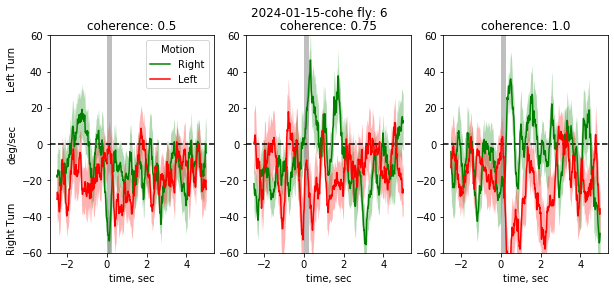

In [18]:
date = "2024-01-15-cohe" # DATE HERE
fly = 6 #FLY HERE

hdf5_file = os.path.join(root_dir,date,date+'.hdf5')
with h5py.File(hdf5_file, "r") as f:

    data = f['Subjects'][F'fly_{fly}']['epoch_runs']['series_'+str(fly+1).zfill(3)]
    fictrac_data = extract_fictrac_data(data)
    stim_data = extract_stimulus_data(data)

    resolution = 0.01 #100Hz
    fictrac_data, stim_data = interpolate(fictrac_data, stim_data, resolution)
    beh_traces = extract_beh_traces(fictrac_data, stim_data, resolution)

    traces = make_figure(save=False,view=True)

### for many flies

In [18]:
### list of dates. can be single dates or multiple.
dates = ["2024-01-18-cohe"]

In [29]:
all_traces = {}
all_traces['left'] = {}
all_traces['right'] = {}

for coherence in [.1,.2,0.25,.3,0.5,.75,1]:
    all_traces['left'][coherence] = np.zeros((0,750))
    all_traces['right'][coherence] = np.zeros((0,750))

for date in dates:
    print(date)
    hdf5_file = os.path.join(root_dir,date,date+'.hdf5')
    with h5py.File(hdf5_file, "r") as f:
        num_flies = len(f['Subjects'].keys())

        for fly in range(num_flies):
            print(fly)
            data = f['Subjects'][F'fly_{fly}']['epoch_runs']['series_'+str(fly+1).zfill(3)]

            try:
                fictrac_data = extract_fictrac_data(data)
            except KeyError as e:
                print(e)
                continue
            stim_data = extract_stimulus_data(data)

            resolution = 0.01 #100Hz
            fictrac_data, stim_data = interpolate(fictrac_data, stim_data, resolution)
            beh_traces = extract_beh_traces(fictrac_data, stim_data, resolution)

            traces = make_figure(save=False,view=False)
            
            for direction in ['left', 'right']:
                coherences = traces[direction].keys()
                for cohe in coherences:
                    all_traces[direction][cohe] = np.concatenate((all_traces[direction][cohe],np.asarray(traces[direction][cohe])),axis=0)
                    

2024-01-08-cohe
0
[0.1, 0.2, 0.3]
1
[0.1, 0.2, 0.3]
2
[0.1, 0.2, 0.3]
3
[0.1, 0.2, 0.3]
4
[0.1, 0.2, 0.3]
2023-12-20
0
[0.25, 0.5, 1.0]
1
[0.25, 0.5, 1.0]
2
[0.25, 0.5, 1.0]
2023-12-25-cohe
0
[0.1, 0.2, 0.3]
1
[0.1, 0.2, 0.3]
2023-12-22-cohe
0
[0.1, 0.2, 0.3]
1
[0.1, 0.2, 0.3]
2024-01-09-cohe
0
[0.1, 0.2, 0.3]
1
"Unable to open object (object 'behavior' doesn't exist)"
2024-01-07
0
"Unable to open object (object 'behavior' doesn't exist)"
1
"Unable to open object (object 'behavior' doesn't exist)"
2
"Unable to open object (object 'behavior' doesn't exist)"
3
"Unable to open object (object 'behavior' doesn't exist)"
2023-12-21
0
[0.25, 0.5, 1.0]
1
[0.25, 0.5, 1.0]
2
[0.25, 0.5, 1.0]
3
[0.25, 0.5, 1.0]
4
[0.25, 0.5, 1.0]


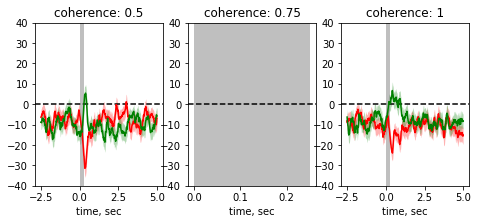

In [24]:
plt.figure(figsize=(16,3))

colors = {'left':'red', 'right':'green'}
duration = 750
xs = [(i-stim_data['pre_time'][0]*100)/100 for i in list(range(duration))]

for j,coherence in enumerate([0.5,.75,1]):
    
    plt.subplot(1,6,j+1)
    plt.axhline(0,color='k',linestyle='--')
    plt.axvspan(0, stim_data['stim_time'][0], facecolor='grey', alpha=0.5)
    plt.xlabel('time, sec')
    
    for direction in ['left', 'right']:
        color=colors[direction]
        meantrace = np.mean(all_traces[direction][coherence],axis=0)
        num_epochs = all_traces[direction][coherence].shape[0]
        std = np.std(all_traces[direction][coherence],axis=0)/np.sqrt(num_epochs)
        plt.fill_between(xs, meantrace-std, meantrace+std, color=color,alpha=0.3,lw=0)
        plt.plot(xs, meantrace, color=color, label=direction)

        plt.ylim(-40,40)
#         if j == 0:
#             plt.ylabel('deg/sec')
#             plt.legend(title='Motion')
#             plt.text(s='Right Turn',rotation=90,x=-5,y=-60)
#             plt.text(s='Left Turn',rotation=90,x=-5,y=30)

        plt.title(F'coherence: {coherence}')

        # save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
        # timestr = strftime("%Y%m%d-%H%M%S")
        # fname = os.path.join(save_path, f'{timestr}'+'flag')
        # plt.savefig(fname,dpi=300,bbox_inches='tight',transparent=False)